# Load libraries

In [1]:
import h5py
import pandas as pd
import numpy as np
import torch
import polars as pl
import gc # Garbage collector
import math
import matplotlib.pyplot as plt

# Read the inputs.

In [2]:
signal_df = pl.read_csv('../data/signal_test.csv')
background_df = pl.read_csv('../data/background_test.csv')

In [3]:
# define the features you are interested in
input_features = signal_df.columns
df_signal_filtered = signal_df[input_features]
df_background_filtered = background_df[input_features]

# Prepare targes, features for learning

In [4]:
# Set targets for training
y_signal     = np.ones(len(df_signal_filtered))
y_background = np.zeros(len(df_background_filtered))
print(len(y_signal))
print(len(y_background))

87344
60687


In [5]:
# Combine the dataframes as one big numpy array
input_data = np.concatenate((df_signal_filtered, df_background_filtered), axis=0)
target     = np.concatenate((y_signal, y_background), axis=0)

In [6]:

# split data into train, validation, and test sets (You can also do the shuffle here, if not shuffled before)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_indices, test_indices = next(sss.split(input_data, target))

X_train, y_train = input_data[train_indices], target[train_indices]
X_temp, y_temp = input_data[test_indices], target[test_indices]
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True)

# Choose device for training

In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class LogScaler(BaseEstimator, TransformerMixin):
    def __init__(self, offset=1e-3, add_mask = False):
        self.offset = offset
        self.add_mask = add_mask

    def fit(self, X, y=None):
        return self  # no fitting needed

    def transform(self, X):
        log = np.log(X + self.offset)
        # Create a mask for nan values
        mask = np.isnan(log)
        if self.add_mask:
            return np.hstack([mask, log])
        return log

class PhiTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        sin_phi = np.sin(X)
        cos_phi = np.cos(X)
        return np.hstack([sin_phi, cos_phi])


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler


energy_indices = [0, 1, 2, 3, 4, 5, 6]  # Assuming these are the indices for energy features
eta_indices = [7, 8, 9, 10, 11, 12, 13]  # Assuming these are the indices for eta features
phi_indices = [14, 15, 16, 17, 18, 19, 20]  # Assuming these are the indices for phi features
pt_indices = [21, 22, 23, 24, 25, 26, 27]  # Assuming these are the indices for pt features
btag_indices = [28, 29, 30, 31, 32, 33, 34]  # Assuming these are the indices for b-tag features
scaler = ColumnTransformer(
    [('E', LogScaler(add_mask=True), energy_indices),
    ('phi', PhiTransformer(), phi_indices),
    ('eta',StandardScaler(), eta_indices),
    ('pt',LogScaler(), pt_indices),
    ('btag', MinMaxScaler(), btag_indices)
    ],
    remainder='passthrough'
)

test_data_transformed = scaler.fit_transform(input_data[:100])
test_data_transformed[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  5.58436715,  7.07190969,  4.55864393,
        4.14008536,  3.05062277,         nan,         nan,  0.97400595,
       -0.07897095, -0.30164302, -0.7939183 , -0.53850095,         nan,
               nan,  0.22652242,  0.99687692, -0.95342094, -0.60802445,
       -0.8426249 ,         nan,         nan,  0.98872678, -1.67164578,
       -0.79807162,  0.53173417,  0.067607  ,         nan,         nan,
        4.24527056,  4.23450162,  3.77283593,  3.917207  ,  3.05062277,
               nan,         nan,  0.66666667,  0.        ,  0.        ,
        0.        ,  0.        ,         nan,         nan,  0.        ,
        0.        ,  1.        , -1.        ,  0.        ,         nan,
               nan,  1.        ,  1.        ,  3.        ,  4.        ,
        5.        ,         nan,         nan])

In [9]:
# Scale the data to lie between -1 and 1 using sklearn StandardScaler
from sklearn.preprocessing import MinMaxScaler
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

In [10]:
# As tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)

# Define the model

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleDNN(nn.Module):
    def __init__(self, N_input_features): # You can add more parameters here, such that the size of all layers can be
        # defined in the constructor
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(SimpleDNN, self).__init__()
        self.linear1 = nn.Linear(N_input_features, N_input_features)
        self.linear2 = nn.Linear(N_input_features, 30)
        self.linear3 = nn.Linear(30, 20)
        self.linear4 = nn.Linear(20, 1)
        self.dropput = nn.Dropout(p=0.1)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # Compute the forward pass.
        # The first layer is self.linear1, then we apply the ReLU activation function
        x1     = F.relu(self.linear1(x))
        x1dp = self.dropput(x1)
        # layer2
        x2     = F.relu(self.linear2(x1dp))
        x2dp = self.dropput(x2)
        #layer 3
        x3     = F.relu(self.linear3(x2dp))
        x3dp   = self.dropput(x3)
        # The final layer is self.linear24 then we apply the sigmoid activation function to get our final output
        y_pred = F.sigmoid(self.linear4(x3dp))
        return y_pred

N_features = 63
model = SimpleDNN(N_features).to(device)

In [12]:
# Define the loss function and optimizer
import torch.optim as optim
criterion = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=0.0001)

# Map the padding to valid inputs

In [13]:
X_train_tensor = torch.nan_to_num(X_train_tensor, nan=-1)
X_val_tensor = torch.nan_to_num(X_val_tensor, nan=-1)
X_test_tensor = torch.nan_to_num(X_test_tensor, nan=-1)

# Train

In [14]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor,
                              y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor,
                              y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor,
                              y_test_tensor)

# Create DataLoader objects for training, validation, and testing in batches
train_loader = DataLoader(train_dataset, batch_size=10000, shuffle=True, num_workers=10, persistent_workers=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=5000, shuffle=False, num_workers=10, persistent_workers=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=8)

In [15]:
# Training loop on mini-batches with loss stored for plotting
train_losses = []
val_losses = []
num_epochs = 600

for epoch in range(num_epochs):
    model.train()
    # run over batches of data
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs_device = inputs.to(device)
        targets_device = targets.to(device)
        outputs = model(inputs_device)
        loss = criterion(outputs.squeeze(), targets_device)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # compute avergae loss over all batches
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs_device = inputs.to(device)
            targets_device = targets.to(device)
            outputs = model(inputs_device)
            loss = criterion(outputs.squeeze(), targets_device)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/600, Train Loss: 0.6742, Val Loss: 0.6599
Epoch 2/600, Train Loss: 0.6508, Val Loss: 0.6385
Epoch 3/600, Train Loss: 0.6219, Val Loss: 0.5848
Epoch 4/600, Train Loss: 0.5514, Val Loss: 0.4729
Epoch 5/600, Train Loss: 0.4745, Val Loss: 0.4243
Epoch 6/600, Train Loss: 0.4445, Val Loss: 0.4074
Epoch 7/600, Train Loss: 0.4301, Val Loss: 0.3971
Epoch 8/600, Train Loss: 0.4211, Val Loss: 0.3907
Epoch 9/600, Train Loss: 0.4131, Val Loss: 0.3834
Epoch 10/600, Train Loss: 0.4052, Val Loss: 0.3768
Epoch 11/600, Train Loss: 0.3988, Val Loss: 0.3711
Epoch 12/600, Train Loss: 0.3941, Val Loss: 0.3685
Epoch 13/600, Train Loss: 0.3905, Val Loss: 0.3670
Epoch 14/600, Train Loss: 0.3883, Val Loss: 0.3677
Epoch 15/600, Train Loss: 0.3862, Val Loss: 0.3625
Epoch 16/600, Train Loss: 0.3826, Val Loss: 0.3600
Epoch 17/600, Train Loss: 0.3804, Val Loss: 0.3570
Epoch 18/600, Train Loss: 0.3781, Val Loss: 0.3566
Epoch 19/600, Train Loss: 0.3785, Val Loss: 0.3538
Epoch 20/600, Train Loss: 0.3735, Val Lo

# Check the loss

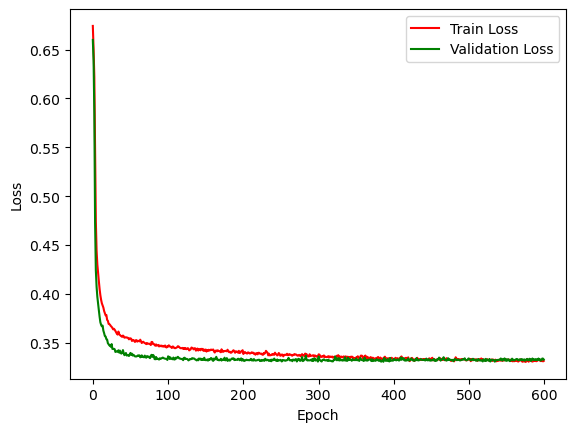

In [16]:
# Plot loss function for training and validation sets
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss', color='red')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])

# Save model (if good?)

In [17]:
save_model = False
if save_model:
    torch.save(model.state_dict(), 'model_weights.pth')

# Performance evaluation

In [18]:
# Evaluate the model on the test dataset
# per default  PyTorch will add the predicted values to the computation graph
# Call the detach() method to remove them
load_model = False
if load_model:
    model = SimpleDNN(N_features)
    model.load_state_dict(torch.load('model_weights.pth', weights_only=True))

model.to('cpu')
model.eval()
y_pred = model(X_test_tensor).detach()

In [19]:
# Filter the predicted events for true Signal and true Background
true_signal = y_pred[y_test==1].numpy()
true_bkg = y_pred[y_test==0].numpy()

(0.0, 1.0)

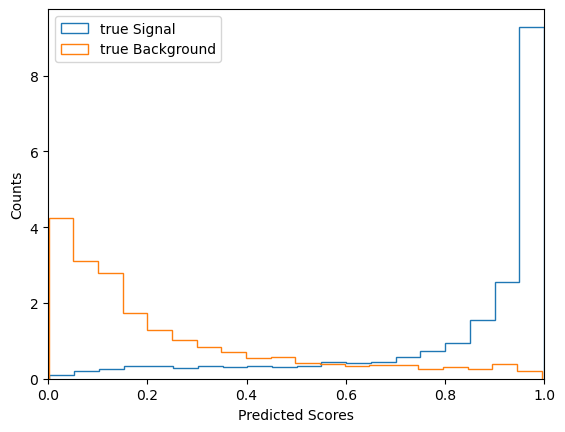

In [20]:
# Plot the predicted scores for both true Signal and true Background events
import matplotlib.pyplot as plt
plt.hist(true_signal, bins=20, histtype='step', label='Signal', density=True)
plt.hist(true_bkg, bins=20, histtype='step', label='Background', density=True)
plt.legend(["true Signal","true Background"])
plt.xlabel("Predicted Scores")
plt.ylabel("Counts")
plt.xlim((0.0,1.0))

In [21]:
# sklearn.metrics require exact value matches, so we need to round to 0 or 1
final_prediction_score =y_pred.numpy()
final_prediction = np.round(final_prediction_score)

In [22]:
# Compute the accuracy_score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, final_prediction)
print(accuracy)

0.8515941637395299


In [23]:
# Caclulate some other metrics that are suitable for a classification
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
precision = precision_score(y_test, final_prediction, average='weighted')
recall = recall_score(y_test, final_prediction, average='weighted')
f1 = f1_score(y_test, final_prediction, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.8528848145435517
Recall: 0.8515941637395299
F1 Score: 0.8520216022565738


In [24]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test,final_prediction_score)

np.float64(0.9272182077007933)

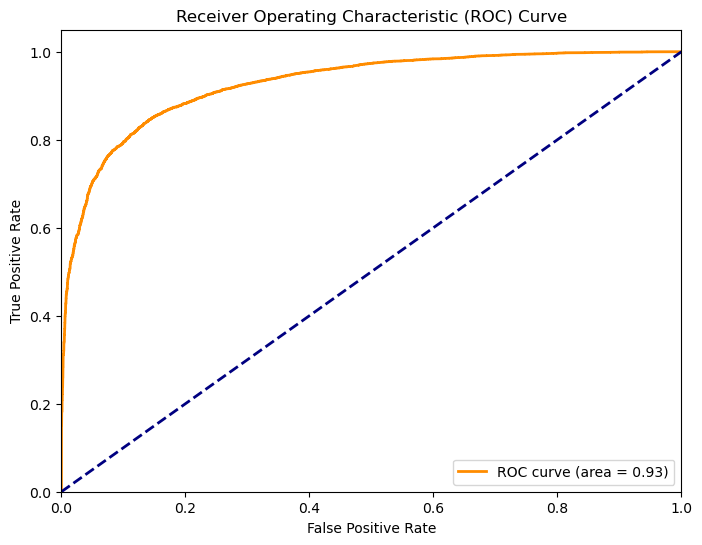

In [25]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, final_prediction_score)

# Compute AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [94]:
# Compute feature importance of 26 input features to DNN
import numpy as np

def accuracy_score(y,x):
    a = y_val_tensor.detach().numpy()
    b = x[:,0]

    return sum((a - b)**2)/len(a)

def permutation_importance(model, X_val_tensor, y_val):

    detach_to_binary = lambda x: np.round(model(x).detach().numpy(),decimals=6)

    baseline_score = accuracy_score(y_val, detach_to_binary(X_val_tensor))  # For a classification task
    importances = []

    for feature_idx in range(X_val_tensor.shape[1]):
        # Shuffle the values of the current feature
        X_val_shuffled = X_val_tensor.clone()
        X_val_shuffled[:, feature_idx] = X_val_shuffled[:, feature_idx][torch.randperm(X_val.shape[0])]

        # Recalculate the performance
        score_shuffled = accuracy_score(y_val, detach_to_binary(X_val_shuffled))
        print(score_shuffled)

        # The difference in performance is the importance of this feature
        importances.append(100*(baseline_score - score_shuffled)/baseline_score)

    return np.array(importances)

# Usage example
importances = permutation_importance(model, X_val_tensor, y_val_tensor)

0.1142488
0.108876094
0.10852932
0.108636215
0.11051746
0.10948805
0.108180925
0.10781459
0.10784463
0.10783203
0.1077354
0.10773234
0.10871467
0.109414294
0.10755106
0.10767834
0.10767452
0.107615314
0.10753451
0.11107747
0.10948171
0.14058565
0.12733103
0.11211066
0.1129096
0.10894697
0.10967635
0.108758904
0.18323371
0.1802806
0.112961575
0.11021672
0.11005378
0.11102209
0.10774484
0.11012171
0.10929065
0.11079485
0.108443215
0.10764746
0.11017925
0.11083814
0.10758637
0.10758637
0.107814
0.10787733
0.10758982
0.10910584
0.10864808
0.10758637
0.10758637
0.10788334
0.10756004
0.10774052
0.11188751
0.10840916


In [95]:
idx = np.argsort(np.asarray(importances))

In [96]:
sorted_features_descending = np.array(signal_df.columns)[idx]

for i in range(len(sorted_features_descending)):
    print(f"Feature: {sorted_features_descending[i]}, Importance: {importances[idx[i]]:.4f}")

IndexError: index 54 is out of bounds for axis 0 with size 49

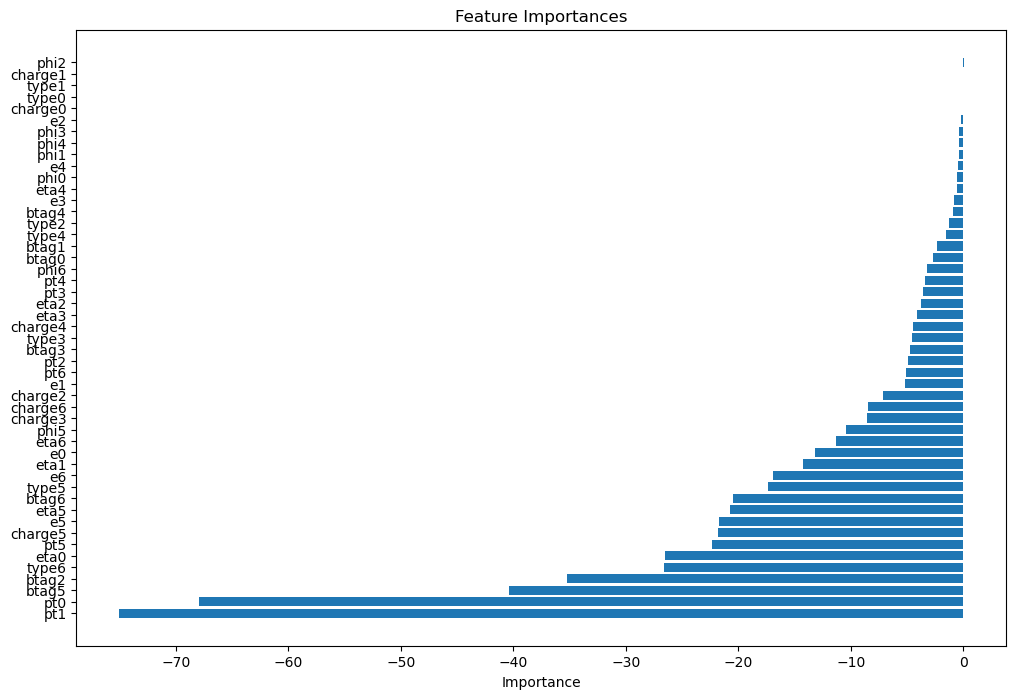

In [43]:
# Plot feature importances
import matplotlib.pyplot as plt
importances = importances[idx]
plt.figure(figsize=(12, 8))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), sorted_features_descending)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()